In [434]:
# ATSC 500 Project Code 
# Separate heatwave vs. non-heatwave days for CMIP6 and ERA5 data 
# Find DTR for HW v. nonHW days
# Calculate biases 
# Mina Deshler

import xarray as xr
xr.set_options(display_style='html')
import intake
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy
import xesmf as xe
import datetime as dt
from datetime import datetime

In [435]:
# Load temperature data
gfdl_temps = xr.open_zarr('maxmintemps2.zarr')
#era5_DTR = xr.open_zarr("era5_DTR_regrid.zarr")
# Regridded ERA5 data
era5_tmin = xr.open_zarr("era5_Tmin_regrid.zarr")
era5_tmax = xr.open_zarr("era5_Tmax_regrid.zarr")

In [436]:
# Load surface sensible heat flux data
gfdl_sshf = xr.open_zarr('amip_hfss_best.zarr') #this is the 3-hourly data

In [437]:
# Open regridded SSHF data min/max values from ERA5: 
era5_sshf_min = xr.open_zarr("era5_SSHFmin_regrid.zarr")
era5_sshf_max = xr.open_zarr("era5_SSHFmax_regrid.zarr")

In [438]:
# Isolate one grid cell in CMIP6 to make comparisons (lat = 49.5, lon = 239.375, approx. coords of Lytton)
gfdl_temps1 = gfdl_temps.isel(lat=0,lon=14) 
era5_tmin1 = era5_tmin.isel(lat=0,lon=11) 
era5_tmax1 = era5_tmax.isel(lat=0,lon=11) #lon is different in ERA5 

gfdl_sshf1 = gfdl_sshf.isel(lat=0,lon=14)
era5_sshf_min1 = era5_sshf_min.isel(lat=0,lon=11) 
era5_sshf_max1 = era5_sshf_max.isel(lat=0,lon=11) 

In [439]:
# check for correct lat/lons
print(gfdl_temps1)
print(era5_tmin1)

<xarray.Dataset>
Dimensions:         (dcpp_init_year: 1, bnds: 2, member_id: 1, time: 1012)
Coordinates:
  * dcpp_init_year  (dcpp_init_year) float64 nan
    lat             float64 49.5
    lat_bnds        (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    lon             float64 239.4
    lon_bnds        (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * time            (time) object 2004-06-01 12:00:00 ... 2014-08-31 12:00:00
    time_bnds       (time, bnds) object dask.array<chunksize=(1012, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tasmax          (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 506), meta=np.ndarray>
    tasmin          (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 506), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMI

In [440]:
# Get daily min/max values for SSHF (do this after isolating one grid cell in CMIP6):
gfdl_sshf1_max = gfdl_sshf1.resample(time='1D').max()
gfdl_sshf1_min = gfdl_sshf1.resample(time='1D').min()

In [441]:
# Make sure using same datetime conventions for all datasets
gfdl_sshf1_max['time'] = gfdl_sshf1_max['time'].astype("datetime64[ns]").dt.date
gfdl_sshf1_min['time'] = gfdl_sshf1_min['time'].astype("datetime64[ns]").dt.date
gfdl_temps1['time'] = gfdl_temps1['time'].astype("datetime64[ns]").dt.date

era5_tmin1['time'] = (pd.to_datetime(era5_tmin1.time)).date
era5_tmax1['time'] = (pd.to_datetime(era5_tmax1.time)).date
era5_sshf_min1['time'] = (pd.to_datetime(era5_sshf_min1.time)).date
era5_sshf_max1['time'] = (pd.to_datetime(era5_sshf_max1.time)).date

In [442]:
# When resampling, saves unnecessary non-summer data, so filter this out:
timeslices = [slice(pd.to_datetime('2004-06-01').date(), pd.to_datetime('2004-08-31').date()), slice(pd.to_datetime('2005-06-01').date(), pd.to_datetime('2005-08-31').date()), slice(pd.to_datetime('2006-06-01').date(), pd.to_datetime('2006-08-31').date()), slice(pd.to_datetime('2007-06-01').date(), pd.to_datetime('2007-08-31').date()),
              slice(pd.to_datetime('2008-06-01').date(), pd.to_datetime('2008-08-31').date()), slice(pd.to_datetime('2009-06-01').date(), pd.to_datetime('2009-08-31').date()), slice(pd.to_datetime('2010-06-01').date(), pd.to_datetime('2010-08-31').date()), slice(pd.to_datetime('2011-06-01').date(), pd.to_datetime('2011-08-31').date()),
              slice(pd.to_datetime('2012-06-01').date(), pd.to_datetime('2012-08-31').date()), slice(pd.to_datetime('2013-06-01').date(), pd.to_datetime('2013-08-31').date()), slice(pd.to_datetime('2014-06-01').date(), pd.to_datetime('2014-08-31').date())]

#timeslices = [slice('2004-06-01T00:00.000000000', '2004-08-31T23:00.000000000'), slice('2005-06-01T00:00.000000000', '2005-08-31T23:00.000000000'), slice('2006-06-01T00:00.000000000', '2006-08-31T23:00.000000000'), slice('2007-06-01T00:00.000000000', '2005-08-31T23:00.000000000'),
#              slice('2008-06-01T00:00.000000000', '2008-08-31T23:00.000000000'), slice('2009-06-01T00:00.000000000', '2009-08-31T23:00.000000000'), slice('2010-06-01T00:00.000000000', '2010-08-31T23:00.000000000'), slice('2011-06-01T00:00.000000000', '2011-08-31T23:00.000000000'),
#              slice('2012-06-01T00:00.000000000', '2012-08-31T23:00.000000000'), slice('2013-06-01T00:00.000000000', '2013-08-31T23:00.000000000'), slice('2014-06-01T00:00.000000000', '2014-08-31T23:00.000000000')]
dset_max = []
dset_min = []
dset_temps = []
for i in timeslices:
    gfdl_max_slice = gfdl_sshf1_max.sel(time = i)
    dset_max.append(gfdl_max_slice)
    gfdl_min_slice = gfdl_sshf1_min.sel(time = i)
    dset_min.append(gfdl_min_slice)
    gfdl_temps_slice = gfdl_temps1.sel(time = i)
    dset_temps.append(gfdl_temps_slice)
gfdl_temps2 = xr.concat(dset_temps,dim="time")
gfdl_sshf_max2 = xr.concat(dset_max,dim="time")
gfdl_sshf_min2 = xr.concat(dset_min,dim="time")
gfdl_sshf_min2

<xarray.Dataset>
Dimensions:         (bnds: 2, dcpp_init_year: 1, member_id: 1, time: 1012)
Coordinates:
  * bnds            (bnds) float64 1.0 2.0
  * dcpp_init_year  (dcpp_init_year) float64 nan
  * member_id       (member_id) object 'r1i1p1f1'
  * time            (time) object 2004-06-01 2004-06-02 ... 2014-08-31
    lat             float64 49.5
    lat_bnds        (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    lon             float64 239.4
    lon_bnds        (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    hfss            (time, member_id, dcpp_init_year) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    no parent
    branch_time_in_child:             0.0
    comment:                          <null ref>
    contact:                          gfdl.climate.model.info@noaa.gov
    ...                               ...
    title:                            NOAA GFDL GFDL-CM4 model output prepare...
    tracking_id:                      hdl:21.14100/a97aa028-bb0e-4dd9-9ffb-61...
    variable_id:                      hfss
    variant_info:                     N/A
    variant_label:                    r1i1p1f1
    version_id:                       v20180701

In [443]:
# Remove repeated times in ERA5 data !!
#_, index = np.unique(era5_tmax1['time'], return_index=True)
#era5_tmin1.isel(time=index)
#era5_tmin1

In [364]:
# Repeat for ERA5 data

#temps_max = []
#temps_min = []
#sshf_max = []
#sshf_min = []
#for i in timeslices:
#    era5_max_slice = era5_tmax1.sel(time = i)
#    temps_max.append(era5_max_slice)
#    era5_min_slice = era5_tmin1.sel(time = i)
#    temps_min.append(era5_min_slice)
#    era5_hfmax_slice = era5_sshf_max1.sel(time = i)
#    sshf_max.append(era5_hfmax_slice)
#    era5_hfmin_slice = era5_sshf_min1.sel(time = i)
#    sshf_min.append(era5_hfmin_slice)
#era5_tmax_final = xr.concat(temps_max,dim="time")
#era5_tmin_final = xr.concat(temps_min,dim="time")
#era5_sshfmax_final = xr.concat(sshf_max,dim="time")
#era5_sshfmin_final = xr.concat(sshf_min,dim="time")
#era5_tmax_final

#timeidx_gfdl = gfdl_temps1.time
#era5_tmin1.drop_duplicates(dim='time')
#era5_tmin1.reindex({"time": timeidx_gfdl})
#era5_tmin1

Using the significance index to identify heatwave days:

In [444]:
# Ti = the avg of daily max and daily min temps 
gfdl_ti = (gfdl_temps2.tasmax*gfdl_temps2.tasmin)/2
era5_ti = (era5_tmax1*era5_tmin1)/2
era5_ti

<xarray.Dataset>
Dimensions:  (time: 994)
Coordinates:
    lat      float64 49.5
    lon      float64 239.4
    number   int32 0
    surface  float64 0.0
  * time     (time) object 1998-05-31 1998-06-01 ... 2014-08-30 2014-08-31
Data variables:
    t2m      (time) float32 dask.array<chunksize=(497,), meta=np.ndarray>

In [445]:
# Use the significance index (Nairn et al 2015) to determine heatwave days 

# Find 95th percentile of Ti - range at which we determine if heatwave or not
gfdl_t95 = np.percentile(gfdl_ti.to_numpy(),95)
era5_t95 = np.percentile(era5_ti.t2m.to_numpy(),95)
print(gfdl_t95)
print(era5_t95)

# If the average of three days in a row is above 95p, save index as heatwave day 
# For GFDL
#save_idx = []
#save_idx2 = []
#for i in range(len(gfdl_ti.time) - 2):
#    tavg = (gfdl_ti.isel(time = i) + gfdl_ti.isel(time = i+1) + gfdl_ti.isel(time = i+2))/3
#    if tavg > gfdl_t95:
#        save_idx.append(i)
#        save_idx.append(i+1)
#        save_idx.append(i+2)
#    else:
#        save_idx2.append(i)
#        save_idx2.append(i+1)
#        save_idx2.append(i+2)
#gfdl_hw_idx = np.unique(save_idx) #to prevent repeats if a heatwave is longer than 3 days 
#gfdl_nohw_idx = np.unique(save_idx2)

41564.7236328125
42688.8173828125


In [446]:
# If the average of three days in a row is above 95p, save index as heatwave day 
# Using ERA5 95th percentile threshold; saving dates for both ERA5 and GFDL
save_idx_era = []
save_idx2_era = []
for i in range(len(era5_ti.time) - 2):
    tavg2 = (era5_ti.t2m.isel(time = i) + era5_ti.t2m.isel(time = i+1) + era5_ti.t2m.isel(time = i+2))/3
    if tavg2 > era5_t95:
        save_idx_era.append(i)
        save_idx_era.append(i+1)
        save_idx_era.append(i+2)
    else:
        save_idx2_era.append(i)
        save_idx2_era.append(i+1)
        save_idx2_era.append(i+2)
era5_hw_idx = np.unique(save_idx_era) #to prevent repeats if a heatwave is longer than 3 days 
era5_nohw_idx = np.unique(save_idx2_era)

print(era5_hw_idx)

[ 73  74  75  76  77  78  79 166 167 168 169 170 330 331 332 333 334 335
 387 388 389 390 391 460 461 462 463 464 465 466 496 497 498 499 528 529
 530 780 781 782 793 794 795 796 838 839 840 841 942 943 944 945 946 947
 948 972 973 974 975]


In [447]:
# Get ERA5 heatwave and non-heatwave temps and SSHF
era5_hw_tmin = era5_tmin1.isel(time = era5_hw_idx)
era5_nohw_tmin = era5_tmin1.isel(time = era5_nohw_idx)
era5_hw_tmax = era5_tmax1.isel(time = era5_hw_idx)
era5_nohw_tmax = era5_tmax1.isel(time = era5_nohw_idx)
era5_hw_sshfmin = era5_sshf_min1.isel(time = era5_hw_idx)
era5_nohw_sshfmin = era5_sshf_min1.isel(time = era5_nohw_idx)
era5_hw_sshfmax = era5_sshf_max1.isel(time = era5_hw_idx)
era5_nohw_sshfmax = era5_sshf_max1.isel(time = era5_nohw_idx)

In [448]:
# Save dates of heatwaves for plugging in to GFDL data
heatwavedays = era5_hw_tmin.time
heatwavedays

<xarray.DataArray 'time' (time: 59)>
array([datetime.date(2004, 8, 11), datetime.date(2004, 8, 12),
       datetime.date(2004, 8, 13), datetime.date(2004, 8, 14),
       datetime.date(2004, 8, 15), datetime.date(2004, 8, 16),
       datetime.date(2004, 8, 17), datetime.date(2007, 7, 11),
       datetime.date(2007, 7, 12), datetime.date(2007, 7, 13),
       datetime.date(2007, 7, 14), datetime.date(2007, 7, 15),
       datetime.date(2006, 7, 20), datetime.date(2006, 7, 21),
       datetime.date(2006, 7, 22), datetime.date(2006, 7, 23),
       datetime.date(2006, 7, 24), datetime.date(2006, 7, 25),
       datetime.date(2008, 8, 14), datetime.date(2008, 8, 15),
       datetime.date(2008, 8, 16), datetime.date(2008, 8, 17),
       datetime.date(2008, 8, 18), datetime.date(2009, 7, 25),
       datetime.date(2009, 7, 26), datetime.date(2009, 7, 27),
       datetime.date(2009, 7, 28), datetime.date(2009, 7, 29),
       datetime.date(2009, 7, 30), datetime.date(2009, 7, 31),
       datetime.date(2008, 6, 29), datetime.date(2008, 6, 30),
       datetime.date(2008, 7, 1), datetime.date(2008, 7, 2),
       datetime.date(2009, 8, 1), datetime.date(2009, 8, 2),
       datetime.date(2009, 8, 3), datetime.date(2012, 8, 4),
       datetime.date(2012, 8, 5), datetime.date(2012, 8, 6),
       datetime.date(2012, 8, 17), datetime.date(2012, 8, 18),
       datetime.date(2012, 8, 19), datetime.date(2012, 8, 20),
       datetime.date(2013, 6, 30), datetime.date(2013, 7, 1),
       datetime.date(2013, 7, 2), datetime.date(2013, 7, 3),
       datetime.date(2014, 7, 11), datetime.date(2014, 7, 12),
       datetime.date(2014, 7, 13), datetime.date(2014, 7, 14),
       datetime.date(2014, 7, 15), datetime.date(2014, 7, 16),
       datetime.date(2014, 7, 17), datetime.date(2014, 8, 10),
       datetime.date(2014, 8, 11), datetime.date(2014, 8, 12),
       datetime.date(2014, 8, 13)], dtype=object)
Coordinates:
    lat      float64 49.5
    lon      float64 239.4
    number   int32 ...
    surface  float64 ...
  * time     (time) object 2004-08-11 2004-08-12 ... 2014-08-12 2014-08-13

In [449]:
# Get the times from ERA5 heatwave indices to plug into GFDL data
gfdl_where = np.in1d(gfdl_temps1.time,heatwavedays)
gfdl_hw_idx = np.where(gfdl_where)
gfdl_nohw_idx = np.where(gfdl_where==False)

gfdl_hw_idx = np.array(gfdl_hw_idx).ravel().tolist()
gfdl_nohw_idx = np.array(gfdl_nohw_idx).ravel().tolist()
#gfdl_hw_idx

In [450]:
# Get GFDL heatwave and non-heatwave temps and SSHF
gfdl_hw_temps = gfdl_temps1.isel(time = gfdl_hw_idx) 
gfdl_nohw_temps = gfdl_temps1.isel(time = gfdl_nohw_idx)

gfdl_hw_maxflux = gfdl_sshf_max2.isel(time = gfdl_hw_idx) 
gfdl_hw_minflux = gfdl_sshf_min2.isel(time = gfdl_hw_idx) 
gfdl_nohw_maxflux = gfdl_sshf_max2.isel(time = gfdl_nohw_idx) 
gfdl_nohw_minflux = gfdl_sshf_min2.isel(time = gfdl_nohw_idx) 

In [451]:
# Get DTR for hw vs non-hw
gfdl_hw_temps['dtr'] = gfdl_hw_temps.tasmax - gfdl_hw_temps.tasmin
gfdl_nohw_temps['dtr'] = gfdl_nohw_temps.tasmax - gfdl_nohw_temps.tasmin
era5_hw_dtr = era5_hw_tmax - era5_hw_tmin
era5_nohw_dtr = era5_nohw_tmax - era5_nohw_tmin

In [452]:
# Convert units for SSHF! GFDL: W/m^2 vs. ERA5: J/m^2
# Energy (turbulent and radiative) and momentum fluxes should be divided by 86400 seconds - 
# Ref: https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation
era5_hw_sshfmax['sshf'] = era5_hw_sshfmax['sshf'] / 86400
era5_hw_sshfmin['sshf'] = era5_hw_sshfmin['sshf'] / 86400
era5_nohw_sshfmax['sshf'] = era5_nohw_sshfmax['sshf'] / 86400
era5_nohw_sshfmin['sshf'] = era5_nohw_sshfmin['sshf'] / 86400

In [453]:
# Plot time series for max, min temps for one heatwave event
aug = np.arange(0,6) #first seven days
era5dtr = era5_hw_dtr.isel(time=aug)
gfdldtr = gfdl_hw_dtr.isel(time=aug)
era5tmax = era5_hw_tmax.isel(time=aug)
era5tmin = era5_hw_tmin.isel(time=aug)
gfdltemps = gfdl_hw_temps.isel(time=aug)

era5maxflux = era5_hw_sshfmax.isel(time=aug)
era5minflux = era5_hw_sshfmin.isel(time=aug)
gfdlmaxflux = gfdl_hw_maxflux.isel(time=aug)
gfdlminflux = gfdl_hw_minflux.isel(time=aug)

time = gfdl_hw_dtr.time[0:6]
gfdldtr.values.squeeze()

array([ 6.2061157, 15.821106 ,  7.3601685,  8.167145 , 12.052673 ,
       12.935577 ], dtype=float32)

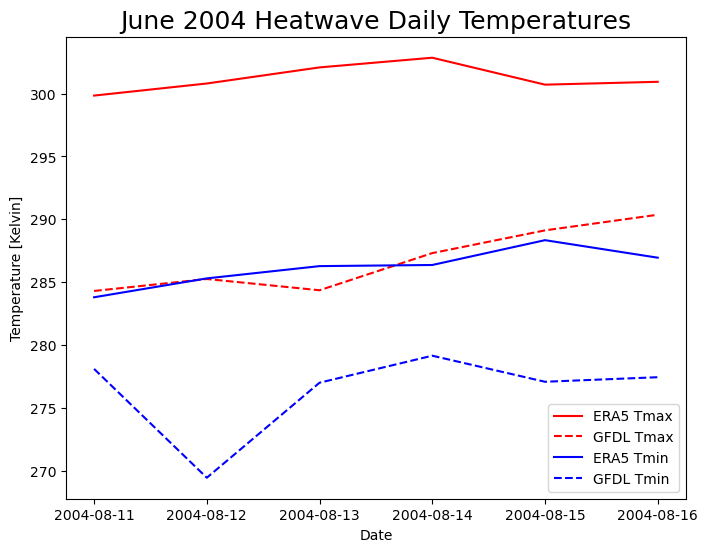

In [517]:
# Plot temperatures 
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(time,era5tmax.t2m.values, label='ERA5 Tmax', linestyle='solid', color='red')
ax.plot(time,gfdltemps.tasmax.values.squeeze(), label='GFDL Tmax', linestyle='dashed', color='red')
ax.plot(time,era5tmin.t2m.values, label='ERA5 Tmin', linestyle='solid', color='blue')
ax.plot(time,gfdltemps.tasmin.values.squeeze(), label='GFDL Tmin', linestyle='dashed', color='blue')

ax.set_title('June 2004 Heatwave Daily Temperatures',fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature [Kelvin]')
ax.legend()
plt.show()

fig.savefig('temps.png')

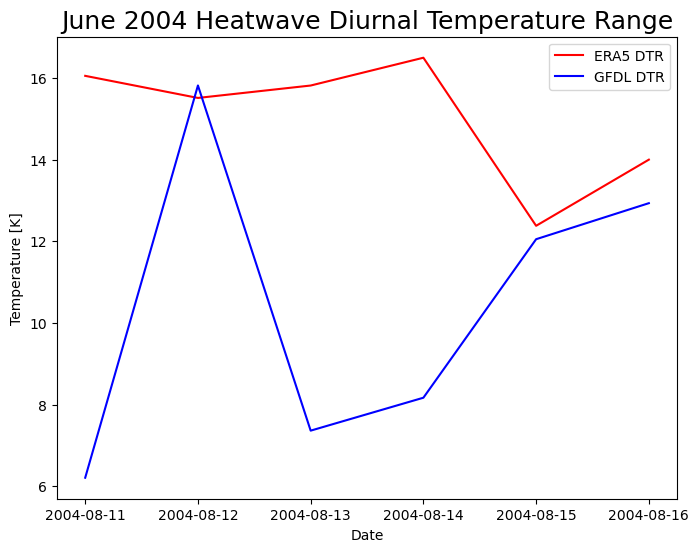

In [518]:
# Plot DTR
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(time,era5dtr.t2m.values, label='ERA5 DTR', linestyle='solid', color='red')
ax.plot(time,gfdldtr.values.squeeze(), label='GFDL DTR', linestyle='solid', color='blue')

ax.set_title('June 2004 Heatwave Diurnal Temperature Range',fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature [K]')
ax.legend()
plt.show()

fig.savefig('dtr.png')

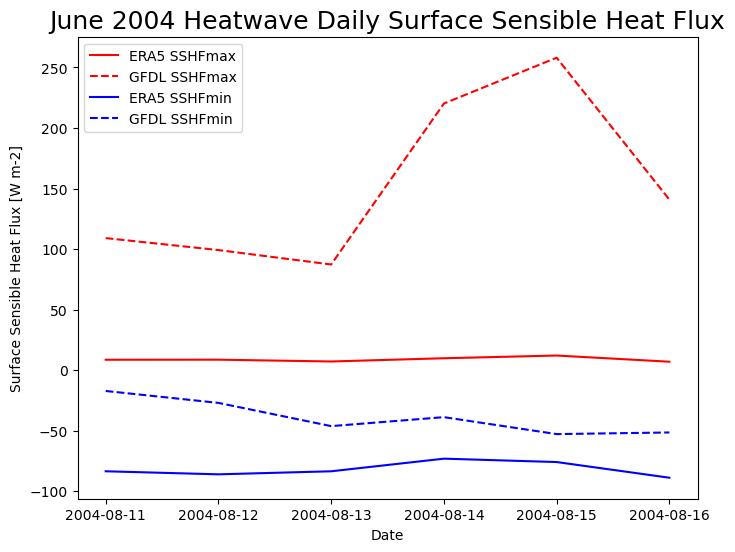

In [519]:
# Plot SSHF max and mins
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(time,era5maxflux.sshf.values, label='ERA5 SSHFmax', linestyle='solid', color='red')
ax.plot(time,gfdlmaxflux.hfss.values.squeeze(), label='GFDL SSHFmax', linestyle='dashed', color='red')
ax.plot(time,era5minflux.sshf.values, label='ERA5 SSHFmin', linestyle='solid', color='blue')
ax.plot(time,gfdlminflux.hfss.values.squeeze(), label='GFDL SSHFmin', linestyle='dashed', color='blue')

ax.set_title('June 2004 Heatwave Daily Surface Sensible Heat Flux',fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel('Surface Sensible Heat Flux [W m-2]')
ax.legend()
plt.show()

fig.savefig('sshf.png') 

In [468]:
# Bias calculations - no heatwave days 
bias_nohw_tmax = gfdl_nohw_temps['tasmax'] - era5_nohw_tmax['t2m']
bias_nohw_tmin = gfdl_nohw_temps['tasmin'] - era5_nohw_tmin['t2m']
bias_nohw_dtr = gfdl_nohw_temps['dtr'] - era5_nohw_dtr['t2m']
bias_nohw_sshfmax = gfdl_nohw_maxflux['hfss'] - era5_nohw_sshfmax['sshf']
bias_nohw_sshfmin = gfdl_nohw_minflux['hfss'] - era5_nohw_sshfmin['sshf']

In [471]:
# Bias calculations - heatwave days
# Tmax, Tmin, DTR, SSHFmax, SSHFmin biases for HW and no HW
bias_hw_tmax = gfdl_hw_temps['tasmax'] - era5_hw_tmax['t2m']
bias_hw_tmin = gfdl_hw_temps['tasmin'] - era5_hw_tmin['t2m']
bias_hw_dtr = gfdl_hw_temps['dtr'] - era5_hw_dtr['t2m']
bias_hw_sshfmax = gfdl_hw_maxflux['hfss'] - era5_hw_sshfmax['sshf']
bias_hw_sshfmin = gfdl_hw_minflux['hfss'] - era5_hw_sshfmin['sshf']


In [520]:
# Mean bias error 
mbe_nohw_tmax = np.mean(bias_nohw_tmax)
mbe_nohw_tmin = np.mean(bias_nohw_tmin)
mbe_nohw_dtr = np.mean(bias_nohw_dtr)
mbe_nohw_sshfmax = np.mean(bias_nohw_sshfmax)
mbe_nohw_sshfmin = np.mean(bias_nohw_sshfmin)

mbe_hw_tmax = np.mean(bias_hw_tmax)
mbe_hw_tmin = np.mean(bias_hw_tmin)
mbe_hw_dtr = np.mean(bias_hw_dtr)
mbe_hw_sshfmax = np.mean(bias_hw_sshfmax)
mbe_hw_sshfmin = np.mean(bias_hw_sshfmin)

print(mbe_hw_tmax.values)
print(mbe_hw_tmin.values)
print(mbe_hw_dtr.values)
print(mbe_hw_sshfmax.values)
print(mbe_hw_sshfmin.values)

print(mbe_nohw_tmax.values)
print(mbe_nohw_tmin.values)
print(mbe_nohw_dtr.values)
print(mbe_nohw_sshfmax.values)
print(mbe_nohw_sshfmin.values)

-10.305043
-6.2077494
-4.097295
168.84853049762577
44.70878556499962
-2.5090601
-1.1324445
-1.3766159
170.55041252390225
50.774459793356925


In [521]:
# RMSE calculations for temps *square biases, sum, divide by N, then square root
rmse_nohw_tmax = np.sqrt(np.sum(bias_nohw_tmax**2)/len(bias_nohw_tmax.time))
rmse_hw_tmax = np.sqrt(np.sum(bias_hw_tmax**2)/len(bias_hw_tmax.time))
rmse_nohw_tmin = np.sqrt(np.sum(bias_nohw_tmin**2)/len(bias_nohw_tmin.time))
rmse_hw_tmin = np.sqrt(np.sum(bias_hw_tmin**2)/len(bias_hw_tmin.time))

rmse_nohw_dtr = np.sqrt(np.sum(bias_nohw_dtr**2)/len(bias_nohw_dtr.time))
rmse_hw_dtr = np.sqrt(np.sum(bias_hw_dtr**2)/len(bias_hw_dtr.time))

print(rmse_nohw_tmax.values)
print(rmse_hw_tmax.values)
print(rmse_nohw_tmin.values)
print(rmse_hw_tmin.values)
print(rmse_nohw_dtr.values)
print(rmse_hw_dtr.values)

5.704893
10.726219
4.1949406
7.065399
4.8718596
5.3499312


In [522]:
# RMSE calculations for SSHF
rmse_nohw_sshfmax = np.sqrt(np.sum(bias_nohw_sshfmax**2)/len(bias_nohw_sshfmax.time))
rmse_hw_sshfmax = np.sqrt(np.sum(bias_hw_sshfmax**2)/len(bias_hw_sshfmax.time))
rmse_nohw_sshfmin = np.sqrt(np.sum(bias_nohw_sshfmin**2)/len(bias_nohw_sshfmin.time))
rmse_hw_sshfmin = np.sqrt(np.sum(bias_hw_sshfmin**2)/len(bias_hw_sshfmin.time))
print(rmse_nohw_sshfmax.values)
print(rmse_hw_sshfmax.values)
print(rmse_nohw_sshfmin.values)
print(rmse_hw_sshfmin.values)

183.72783333872258
178.6053073428664
61.28189215546295
50.7744336178108


In [523]:
# Correlation coefficient calculations between all temps and all sshf values
# ERA5 (no hw)
r_tmax_sshfmax_era = np.corrcoef(era5_nohw_tmax['t2m'], era5_nohw_sshfmax['sshf'])
r_tmax_sshfmin_era = np.corrcoef(era5_nohw_tmax['t2m'], era5_nohw_sshfmin['sshf'])
r_tmin_sshfmax_era = np.corrcoef(era5_nohw_tmin['t2m'], era5_nohw_sshfmax['sshf'])
r_tmin_sshf_min_era = np.corrcoef(era5_nohw_tmin['t2m'], era5_nohw_sshfmin['sshf'])
r_dtr_sshf_max_era = np.corrcoef(era5_nohw_dtr['t2m'], era5_nohw_sshfmax['sshf'])
r_dtr_sshf_min_era = np.corrcoef(era5_nohw_dtr['t2m'], era5_nohw_sshfmin['sshf'])
# GFDL (no hw)
r_tmax_sshfmax_gfdl = np.corrcoef(gfdl_nohw_temps['tasmax'].squeeze(), gfdl_nohw_maxflux['hfss'].squeeze())
r_tmax_sshfmin_gfdl = np.corrcoef(gfdl_nohw_temps['tasmax'].squeeze(), gfdl_nohw_minflux['hfss'].squeeze())
r_tmin_sshfmax_gfdl = np.corrcoef(gfdl_nohw_temps['tasmin'].squeeze(), gfdl_nohw_maxflux['hfss'].squeeze())
r_tmin_sshf_min_gfdl = np.corrcoef(gfdl_nohw_temps['tasmin'].squeeze(), gfdl_nohw_minflux['hfss'].squeeze())
r_dtr_sshf_max_gfdl = np.corrcoef(gfdl_nohw_temps['dtr'].squeeze(), gfdl_nohw_maxflux['hfss'].squeeze())
r_dtr_sshf_min_gfdl = np.corrcoef(gfdl_nohw_temps['dtr'].squeeze(), gfdl_nohw_minflux['hfss'].squeeze())
# ERA5 (hw)
hwr_tmax_sshfmax_era = np.corrcoef(era5_hw_tmax['t2m'], era5_hw_sshfmax['sshf'])
hwr_tmax_sshfmin_era = np.corrcoef(era5_hw_tmax['t2m'], era5_hw_sshfmin['sshf'])
hwr_tmin_sshfmax_era = np.corrcoef(era5_hw_tmin['t2m'], era5_hw_sshfmax['sshf'])
hwr_tmin_sshf_min_era = np.corrcoef(era5_hw_tmin['t2m'], era5_hw_sshfmin['sshf'])
hwr_dtr_sshf_max_era = np.corrcoef(era5_hw_dtr['t2m'], era5_hw_sshfmax['sshf'])
hwr_dtr_sshf_min_era = np.corrcoef(era5_hw_dtr['t2m'], era5_hw_sshfmin['sshf'])
# GFDL (hw)
hwr_tmax_sshfmax_gfdl = np.corrcoef(gfdl_hw_temps['tasmax'].squeeze(), gfdl_hw_maxflux['hfss'].squeeze())
hwr_tmax_sshfmin_gfdl = np.corrcoef(gfdl_hw_temps['tasmax'].squeeze(), gfdl_hw_minflux['hfss'].squeeze())
hwr_tmin_sshfmax_gfdl = np.corrcoef(gfdl_hw_temps['tasmin'].squeeze(), gfdl_hw_maxflux['hfss'].squeeze())
hwr_tmin_sshf_min_gfdl = np.corrcoef(gfdl_hw_temps['tasmin'].squeeze(), gfdl_hw_minflux['hfss'].squeeze())
hwr_dtr_sshf_max_gfdl = np.corrcoef(gfdl_hw_temps['dtr'].squeeze(), gfdl_hw_maxflux['hfss'].squeeze())
hwr_dtr_sshf_min_gfdl = np.corrcoef(gfdl_hw_temps['dtr'].squeeze(), gfdl_hw_minflux['hfss'].squeeze())


In [524]:
# ERA5 (hw)
print('ERA5 heatwave')
print(r_tmax_sshfmax_era[0,1])
print(r_tmax_sshfmin_era[0,1])
print(r_tmin_sshfmax_era[0,1])
print(r_tmin_sshf_min_era[0,1])
print(r_dtr_sshf_max_era[0,1])
print(r_dtr_sshf_min_era[0,1])
# ERA5 (no hw)
print('ERA5 no heatwave')
print(hwr_tmax_sshfmax_era[0,1])
print(hwr_tmax_sshfmin_era[0,1])
print(hwr_tmin_sshfmax_era[0,1])
print(hwr_tmin_sshf_min_era[0,1])
print(hwr_dtr_sshf_max_era[0,1])
print(hwr_dtr_sshf_min_era[0,1])

ERA5 heatwave
0.263961645666341
-0.2930428599169832
-0.05885694735314835
-0.05677010037894075
0.44196399771827366
-0.37475171910576366
ERA5 no heatwave
0.12380271300774716
0.06331942478068459
0.3355112912151005
0.2531772769992326
-0.14387148982815864
-0.13681697121120476


In [525]:
# GFDL (hw)
print('GFDL heatwave')
print(r_tmax_sshfmax_gfdl[0,1])
print(r_tmax_sshfmin_gfdl[0,1])
print(r_tmin_sshfmax_gfdl[0,1])
print(r_tmin_sshf_min_gfdl[0,1])
print(r_dtr_sshf_max_gfdl[0,1])
print(r_dtr_sshf_min_gfdl[0,1])
# GFDL (no hw)
print('GFDL no heatwave')
print(hwr_tmax_sshfmax_gfdl[0,1])
print(hwr_tmax_sshfmin_gfdl[0,1])
print(hwr_tmin_sshfmax_gfdl[0,1])
print(hwr_tmin_sshf_min_gfdl[0,1])
print(hwr_dtr_sshf_max_gfdl[0,1])
print(hwr_dtr_sshf_min_gfdl[0,1])

GFDL heatwave
-0.057944784001080794
0.01239695830299191
-0.00745447839313373
-0.0007418135530182411
-0.05120577151477245
0.013106082649108073
GFDL no heatwave
0.06850861170040891
0.06984708328862688
0.16827720092422332
-0.11848834320675035
-0.10978192355945064
0.1870424728113427
